# クラス分類学習モデルの作成、予測の実行

In [23]:
import os
import random

# basic DS libraries
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# plot libraries
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from seaborn_analyzer import classplot
import graphviz
import pydotplus
from IPython.display import Image
from six import StringIO

%matplotlib inline

# プログレスバー
from tqdm import tqdm

# 機械学習モデル
from sklearn.linear_model import LogisticRegression  # ロジスティック回帰
from sklearn.neighbors import KNeighborsClassifier  # K近傍法
from sklearn.svm import SVC  # サポートベクターマシン
from sklearn.tree import DecisionTreeClassifier, export_graphviz  # 決定木
from sklearn.ensemble import RandomForestClassifier  # ランダムフォレスト
from sklearn.ensemble import AdaBoostClassifier  # AdaBoost
from sklearn.naive_bayes import GaussianNB  # ナイーブ・ベイズ
from sklearn.decomposition import LatentDirichletAllocation as LDA  # 線形判別分析
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA  # 二次判別分析

# データセット分割・評価検証
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# config python file
import config

# 最大表示列数の指定（ここでは50列を指定）
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

# ファイル保存関数（dirがなければ生成する）
def make_dir(dir_name: str):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)


# seedの固定
def fix_seed(seed: int):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)


# 再現性をもたせるためのseed固定
SEED = config.SEED
fix_seed(SEED)

# 2値分類モデルの作成・実行

2値分類モデルを作成、実行し、クラス分類に有用な特徴量を見つける  
決定木以外にも、基本的な2値分類を実施できるモデルを採用し、各モデル間で比較していく。  
精度は重視しないが、accuracyよりもf1スコアを重視する。  
目的変数に偏りがある（不均衡データ、1（5年後以内に死亡）<0（5年語以内に生存））ので、**サンプリング方法を要検討**

In [24]:
df_MB_OS_status_in_5years_dropped = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_DIR
    + "/2.0.4-df_MB_OS_status_in_5years_dropped.pkl"
)
df_MB_OS_status_in_5years_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1042 entries, 0 to 1123
Data columns (total 56 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   LYMPH_NODES_EXAMINED_POSITIVE                                   1042 non-null   float64
 1   NPI                                                             1042 non-null   float64
 2   CELLULARITY                                                     1042 non-null   int64  
 3   CHEMOTHERAPY                                                    1042 non-null   bool   
 4   ER_IHC                                                          1042 non-null   int64  
 5   HER2_SNP6                                                       1042 non-null   int64  
 6   HORMONE_THERAPY                                                 1042 non-null   bool   
 7   INFERRED_MENOPAUSAL_STATE                          

In [25]:
print(df_MB_OS_status_in_5years_dropped.target.value_counts())

print(
    "データセット全体に占める5年後の死亡者のデータの割合： ",
    df_MB_OS_status_in_5years_dropped[
        df_MB_OS_status_in_5years_dropped.target == True
    ].shape[0]
    / df_MB_OS_status_in_5years_dropped.shape[0],
)

False    844
True     198
Name: target, dtype: int64
データセット全体に占める5年後の死亡者のデータの割合：  0.19001919385796545


# 学習データ分割

1. X（説明変数）とy（目的変数）に分割(y=df['target'])
2. train_test_splitによる基本的なデータ分割（train:test=75%:25%）※層化検証など他の分割手法は後で実施  

In [26]:
# Xとyに分割
X = df_MB_OS_status_in_5years_dropped.drop("target", axis=1)
y = df_MB_OS_status_in_5years_dropped["target"]
display(X.tail(), y.tail(), y.value_counts())

,LYMPH_NODES_EXAMINED_POSITIVE,NPI,CELLULARITY,CHEMOTHERAPY,ER_IHC,HER2_SNP6,HORMONE_THERAPY,INFERRED_MENOPAUSAL_STATE,AGE_AT_DIAGNOSIS,RADIO_THERAPY,ER_STATUS,HER2_STATUS,GRADE,PR_STATUS,TUMOR_SIZE,TUMOR_STAGE,TMB_NONSYNONYMOUS,COHORT_2.0,COHORT_3.0,COHORT_5.0,INTCLUST_10,INTCLUST_2,INTCLUST_3,INTCLUST_4ER+,INTCLUST_4ER-,...,CLAUDIN_SUBTYPE_Her2,CLAUDIN_SUBTYPE_LumA,CLAUDIN_SUBTYPE_LumB,CLAUDIN_SUBTYPE_NC,CLAUDIN_SUBTYPE_Normal,CLAUDIN_SUBTYPE_claudin-low,THREEGENE_ER+/HER2- Low Prolif,THREEGENE_ER-/HER2-,THREEGENE_HER2+,HISTOLOGICAL_SUBTYPE_Lobular,HISTOLOGICAL_SUBTYPE_Medullary,HISTOLOGICAL_SUBTYPE_Mixed,HISTOLOGICAL_SUBTYPE_Mucinous,HISTOLOGICAL_SUBTYPE_Other,HISTOLOGICAL_SUBTYPE_Tubular/ cribriform,BREAST_SURGERY_MASTECTOMY,LATERALITY_Right,CANCER_TYPE_DETAILED_Breast Invasive Ductal Carcinoma,CANCER_TYPE_DETAILED_Breast Invasive Lobular Carcinoma,CANCER_TYPE_DETAILED_Breast Invasive Mixed Mucinous Carcinoma,CANCER_TYPE_DETAILED_Breast Mixed Ductal and Lobular Carcinoma,ONCOTREE_CODE_IDC,ONCOTREE_CODE_ILC,ONCOTREE_CODE_IMMC,ONCOTREE_CODE_MDLC
1119,4.0,5.060,3,False,1,2,True,1,71.22,False,1,-1,2.0,1,30.0,2.0,14.382695,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1
1120,0.0,2.040,3,False,1,2,False,1,70.65,True,1,-1,1.0,1,20.0,1.0,11.767659,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
1121,0.0,4.040,3,False,-1,3,False,1,75.62,False,-1,-1,3.0,-1,20.0,1.0,5.230071,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0
1122,6.0,5.040,3,True,1,2,False,1,52.84,True,1,-1,2.0,1,20.0,2.0,6.537589,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1
1123,0.0,3.044,3,False,1,2,False,1,63.20,True,1,-1,2.0,1,22.0,2.0,3.922553,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0


1119    False
1120    False
1121    False
1122    False
1123    False
Name: target, dtype: bool

False    844
True     198
Name: target, dtype: int64

In [27]:
# trainとtestに分割

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=config.SEED)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
display(y_train.value_counts(), y_test.value_counts())

(781, 55)

(261, 55)

(781,)

(261,)

False    638
True     143
Name: target, dtype: int64

False    206
True      55
Name: target, dtype: int64

# 学習データの分布をプロット

オーバーサンプリング手法がどのように目的変数を生成しているのかを可視化する。  
x,y軸には以下の２パターンを描画する  
1. 3.0.0のノートブックで実施した決定木で重要度の上位に位置した特徴量（["NPI", "THREEGENE_ER-/HER2-"]）
2. float型の特徴量の中で、値がそれなりに分布している特徴量（["AGE_AT_DIAGNOSIS", "TMB_NONSYNONYMOUS"]）

In [28]:
def sns_joinplot(data: pd.DataFrame, plot_columns: list, target: str = "target"):
    sns.jointplot(
        x=plot_columns[0],
        y=plot_columns[1],
        data=data,
        hue=target,
    )
    plt.show()

In [29]:
from sklearn.preprocessing import StandardScaler


def transform_normalization(df: pd.DataFrame):
    # x,y軸の特徴量の標準化
    scaler = StandardScaler()
    scaler.fit(df)
    df = pd.DataFrame(
        scaler.transform(df),
        index=df.index,
        columns=df.columns,
    )
    return df

In [31]:
plot_columns_1 = ["NPI", "THREEGENE_ER-/HER2-"]
plot_columns_2 = ["AGE_AT_DIAGNOSIS", "TMB_NONSYNONYMOUS"]

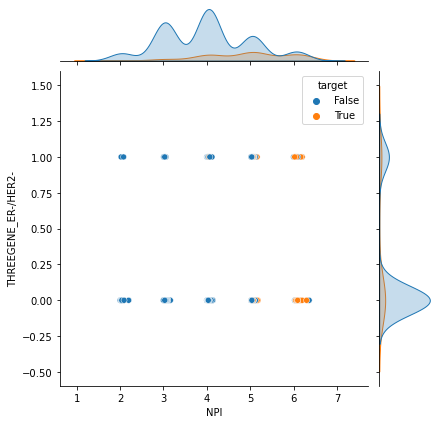

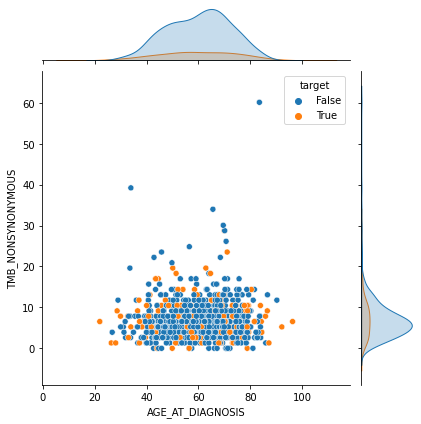

/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/seaborn_analyzer/custom_class_plot.py:252: UserWarning: You passed a edgecolor/edgecolors ('dimgrey') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(group[x_chart[0]].values, group[x_chart[1]].values,
/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/seaborn_analyzer/custom_class_plot.py:224: UserWarning: No contour levels were found within the data range.
  ax.contour(X1, X2, y_pred_pivot,
/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/seaborn_analyzer/custom_class_plot.py:252: UserWarning: You passed a edgecolor/edgecolors ('dimgrey') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This 

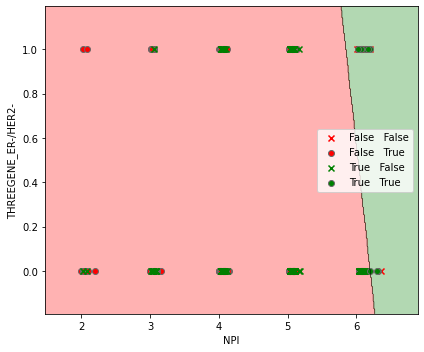

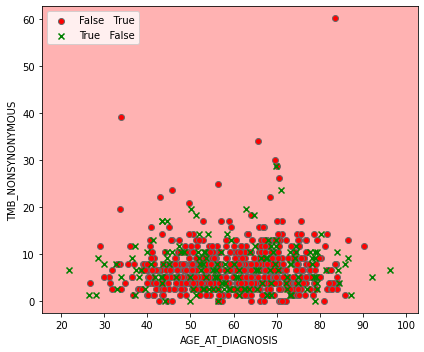

In [32]:
df_tmp = pd.merge(X_train, y_train, left_index=True, right_index=True)

# plot_columns_1の散布図
sns_joinplot(
    df_tmp,
    plot_columns_1,
)
# plot_columns_2の散布図
sns_joinplot(
    df_tmp,
    plot_columns_2,
)

# 標準化
"""
df_tmp = transform_normalization(
    pd.merge(X_train, y_train, left_index=True, right_index=True)[plot_columns_1]
)

sns_joinplot(
    pd.merge(df_tmp, y_train, left_index=True, right_index=True),
    plot_columns=plot_columns_1,
)
df_tmp = transform_normalization(
    pd.merge(X_train, y_train, left_index=True, right_index=True)[plot_columns_2]
)
sns_joinplot(
    pd.merge(df_tmp, y_train, left_index=True, right_index=True),
    plot_columns=plot_columns_2,
)
"""
# plot_columns_1でのロジスティクス回帰の分類図例
classplot.class_separator_plot(LogisticRegression(), plot_columns_1, "target", df_tmp)
# plot_columns_2でのロジスティクス回帰の分類図例
classplot.class_separator_plot(LogisticRegression(), plot_columns_2, "target", df_tmp)

# SMOTEによるオーバーサンプリング
SMOTEと呼ばれる手法によって、不均衡を低減する  
どのようにオーバーサンプリングするのか要確認

In [33]:
sm = SMOTE(random_state=SEED)

X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
y_resampled.value_counts()

True     638
False    638
Name: target, dtype: int64

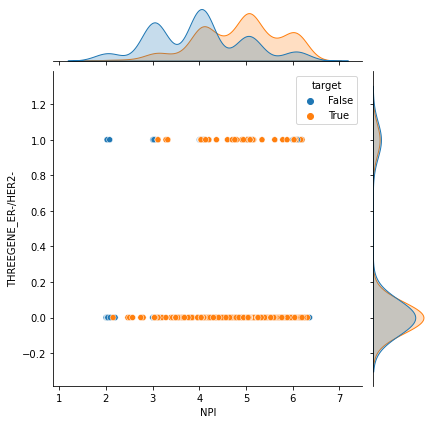

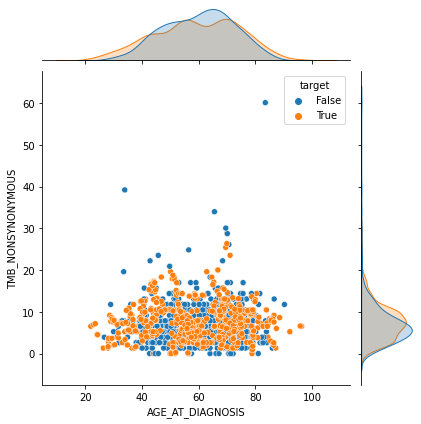

/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/seaborn_analyzer/custom_class_plot.py:252: UserWarning: You passed a edgecolor/edgecolors ('dimgrey') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(group[x_chart[0]].values, group[x_chart[1]].values,
/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/seaborn_analyzer/custom_class_plot.py:252: UserWarning: You passed a edgecolor/edgecolors ('dimgrey') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(group[x_chart[0]].values, group[x_chart[1]].values,


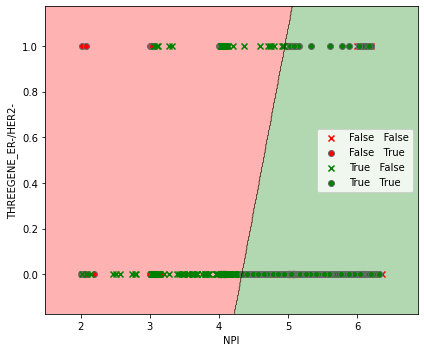

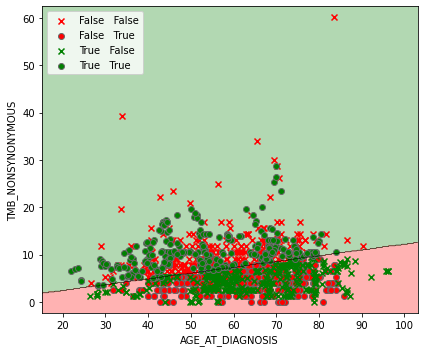

In [34]:
df_tmp = pd.merge(X_resampled, y_resampled, left_index=True, right_index=True)
sns_joinplot(
    df_tmp,
    plot_columns_1,
)
sns_joinplot(
    df_tmp,
    plot_columns_2,
)


# plot_columns_1でのロジスティクス回帰の分類図例
classplot.class_separator_plot(LogisticRegression(), plot_columns_1, "target", df_tmp)
# plot_columns_2でのロジスティクス回帰の分類図例
classplot.class_separator_plot(LogisticRegression(), plot_columns_2, "target", df_tmp)

# 2値分類モデル

In [35]:
def show_scores(y_test: pd.Series, y_pred_tree: pd.Series):
    print("accuracy: ", accuracy_score(y_test, y_pred_tree))
    print("precision: ", precision_score(y_test, y_pred_tree))
    print("recall: ", recall_score(y_test, y_pred_tree))
    print("f1 score: ", f1_score(y_test, y_pred_tree))

In [36]:
def show_confusion_matrix(
    y_test: pd.Series,
    y_pred: pd.Series,
    model_name: str = "confusion matrix",
    display_details: bool = False,
):
    cm = confusion_matrix(y_test, y_pred, normalize="all", labels=[True, False])
    df_cm = pd.DataFrame(data=cm, index=[True, False], columns=[True, False])

    fig = plt.figure()
    sns.heatmap(df_cm, square=True, cbar=True, annot=True, cmap="Blues")
    plt.title(model_name)
    plt.xlabel("Predict label")
    plt.ylabel("True label")
    plt.plot()

    if display_details:
        tn, fp, fn, tp = cm.ravel()
        print("tn: ", tn, "\nfp: ", fp, "\nfn:", fn, "\ntp:", tp)
        show_scores(y_test, y_pred)

## ベースラインの精度

全てFalseと予測（学習データはFalseが多いため）した場合のスコア

False    206
True      55
Name: target, dtype: int64

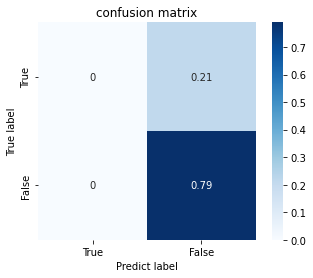

In [37]:
y_base = pd.Series([False for i in range(y_test.shape[0])], index=y_test.index)
display(y_test.value_counts())
show_confusion_matrix(y_test, y_base)

# 様々な機械学習手法の比較

様々な機械学習手法を用いて2値分類を行う。  
簡単に精度を見るため、再現性は担保されていない（引数にrandom_stateを要求しないclfもあるため）ので、必要に応じて再度モデルを構築すること。  
また、パラメータはデフォルト値を使用している。  
そのためパラメータ次第では結果が向上、下降しうる（決定木のf1など）。  

## オーバーサンプリング手法の比較

オーバーサンプリング手法を比較する。  
モデルはデフォルトのものを用い、今回のデータセットに適した・あるいは特徴的なオーバーサンプリングがないか探す。  

### オーバーサンプリングライブラリ
1. imblearn(https://imbalanced-learn.org/stable/over_sampling.html)


In [38]:
bcm_names = [
    "Logistic Regression",
    "Nearest Neighbors",
    "Linear SVM",
    "Polynomial SVM",
    "RBF SVM",
    "Sigmoid SVM",
    "Decision Tree",
    "Random Forest",
    "AdaBoost",
    "Naive Bayes",
    # "Linear Discriminant Analysis", # predictメソッドに対応していない
    "Quadratic Discriminant Analysis",
]

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    SVC(kernel="linear"),
    SVC(kernel="poly"),
    SVC(kernel="rbf"),
    SVC(kernel="sigmoid"),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    # LDA(),
    QDA(),
]

In [47]:
import warnings


def compare_bcms(
    bcm_names: list = bcm_names,
    classifiers: list = classifiers,
    sort_column_name: str = "f1_test",
    average_time: int = 20,
    test_size: float = 0.25,
    over_sampling=None,
    plot_columns: list = ["AGE_AT_DIAGNOSIS", "TMB_NONSYNONYMOUS"],
):
    warnings.filterwarnings("ignore")  # lrで警告が出て視認性が悪いので、いったん非表示
    result = []

    for trial in tqdm(range(average_time)):  # average_time 回繰り返し、指標の平均を見る
        # 乱数の影響を均した平均を取りたいので、SEEDは保留。乱数に依存しない精度を見るので再現性は'ここでは'担保しない。
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size
        )  # 訓練データ・テストデータの生成
        if over_sampling:
            X_train, y_train = sm.fit_resample(X_train, y_train)

        for name, clf in zip(bcm_names, classifiers):  # 指定した複数の分類機を順番に呼び出す
            # 訓練のスコア
            clf.fit(X_train, y_train)  # 学習
            y_pred_train = clf.predict(X_train)
            acc_train = accuracy_score(y_train, y_pred_train)
            f1_train = f1_score(y_train, y_pred_train)
            # 　予測値のスコア
            y_pred = clf.predict(X_test)
            acc_test = accuracy_score(y_test, y_pred)  # 正解率（test）の算出
            f1_test = f1_score(y_test, y_pred)
            result.append([name, acc_train, acc_test, f1_train, f1_test])  # 結果の格納
        # 訓練のプロット
        classplot.class_separator_plot(
            clf,
            plot_columns_1,
            "target",
            pd.merge(X_train, y_train, left_index=True, right_index=True),
        )
        classplot.class_separator_plot(
            clf,
            plot_columns_1,
            "target",
            pd.merge(X_test, y_test, left_index=True, right_index=True),
        )
        classplot.class_separator_plot(
            clf,
            plot_columns_2,
            "target",
            pd.merge(X_train, y_train, left_index=True, right_index=True),
        )
        classplot.class_separator_plot(
            clf,
            plot_columns_2,
            "target",
            pd.merge(X_test, y_test, left_index=True, right_index=True),
        )

    # 表示設定
    df_result = pd.DataFrame(
        result, columns=["classifier", "acc_train", "acc_test", "f1_train", "f1_test"]
    )
    df_result_mean = (
        df_result.groupby("classifier")
        .mean()
        .sort_values(sort_column_name, ascending=False)
    )
    warnings.filterwarnings("always")
    return df_result_mean

数回実行し、再現性がないことと、各モデルが頑健かの確認

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.57s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
RBF SVM,0.723053,0.736590,0.715776,0.488581
Polynomial SVM,0.697908,0.765517,0.651896,0.454791
Logistic Regression,0.868016,0.783908,0.865694,0.417592
Nearest Neighbors,0.871365,0.646743,0.884651,0.391564
AdaBoost,0.881458,0.771264,0.880528,0.391114
Random Forest,1.000000,0.806705,1.000000,0.390807
Naive Bayes,0.743858,0.575287,0.784239,0.382124
Linear SVM,0.874591,0.784674,0.870319,0.378923
Decision Tree,1.000000,0.726054,1.000000,0.337636


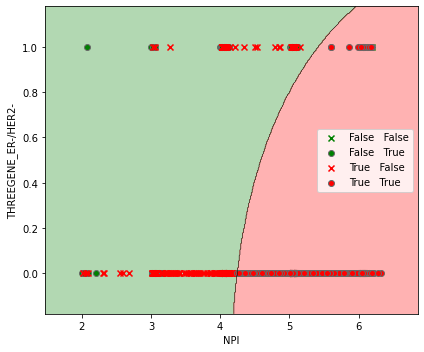

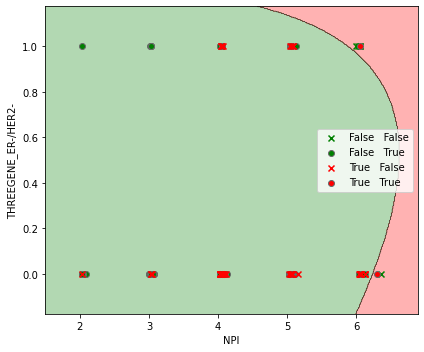

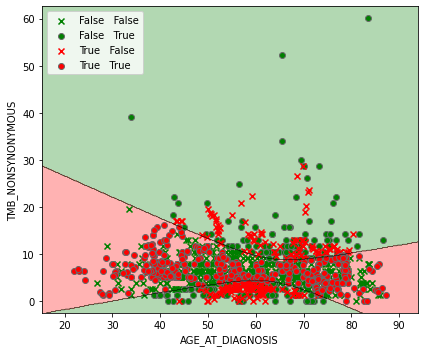

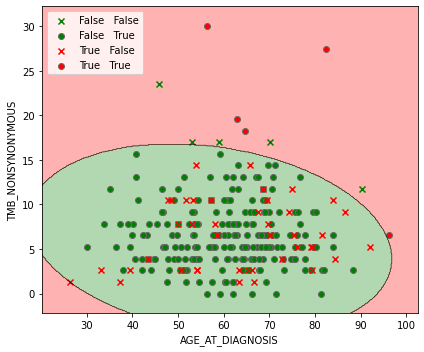

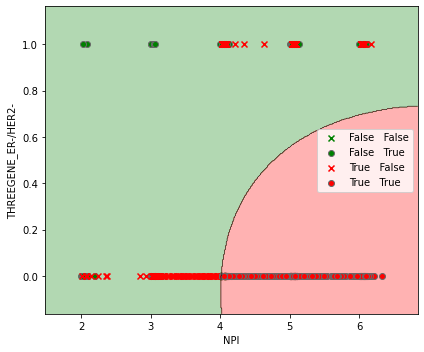

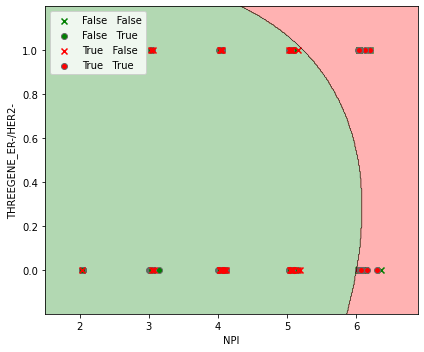

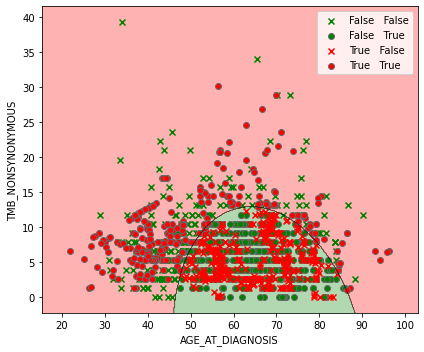

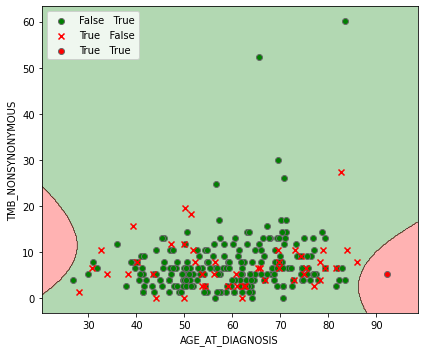

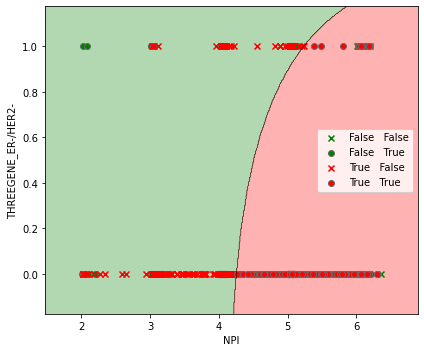

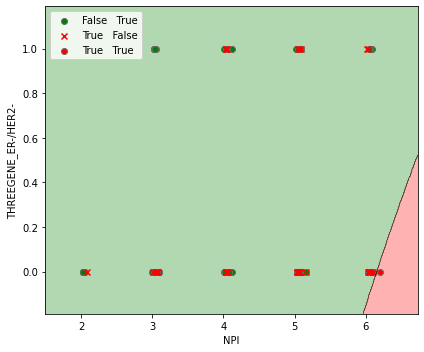

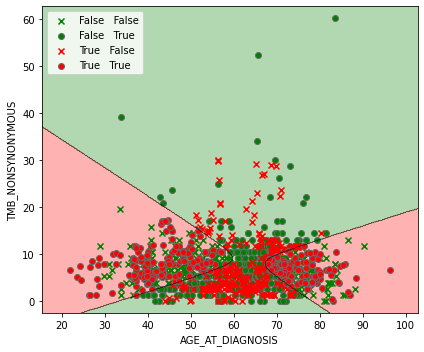

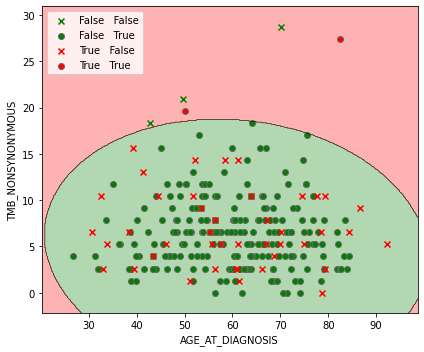

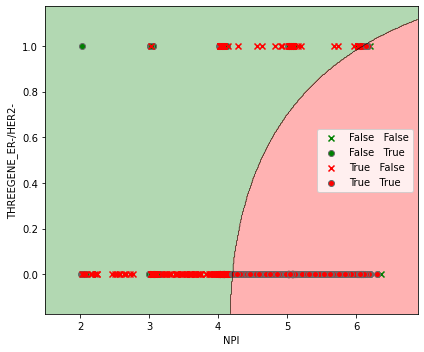

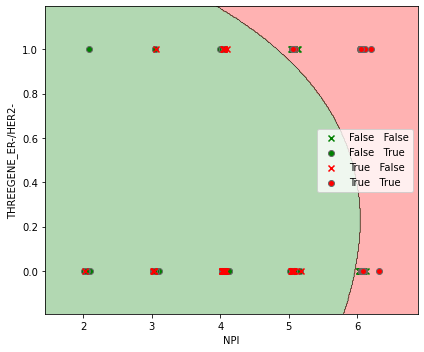

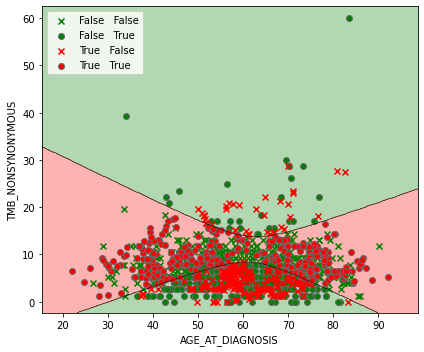

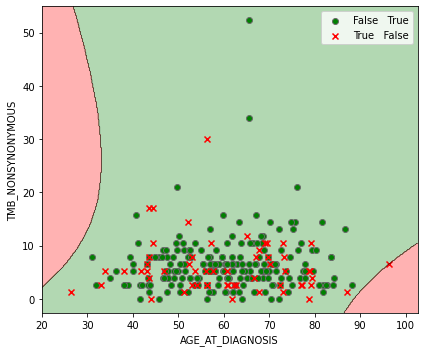

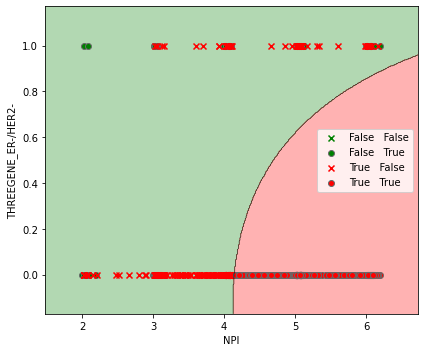

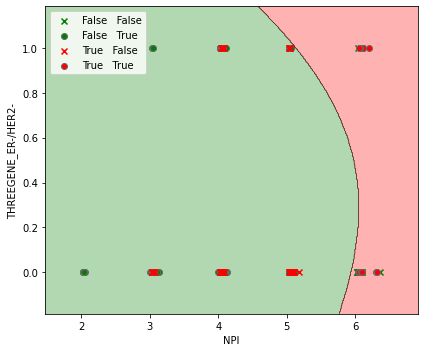

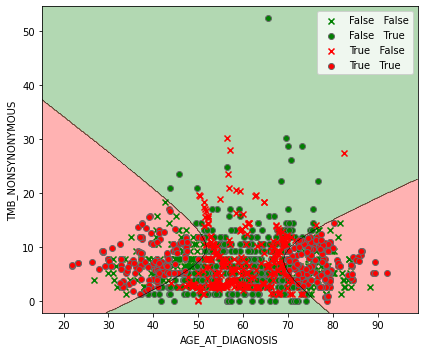

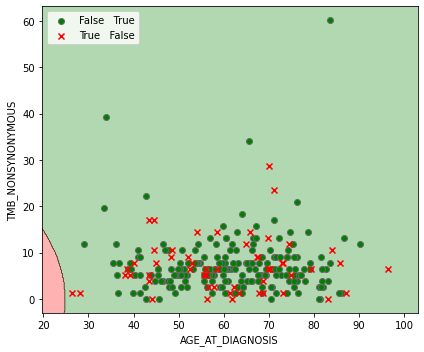

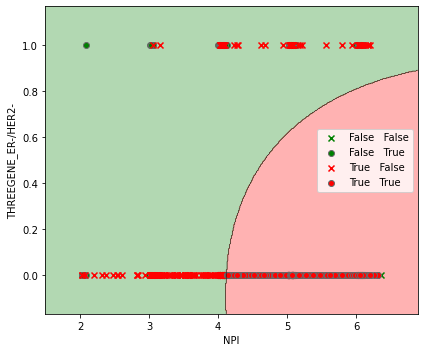

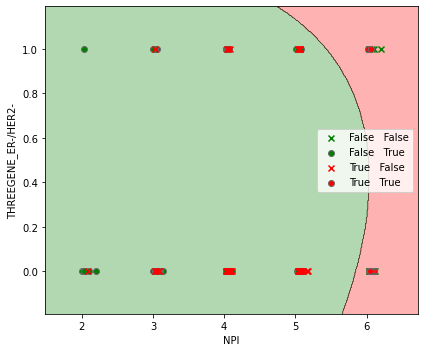

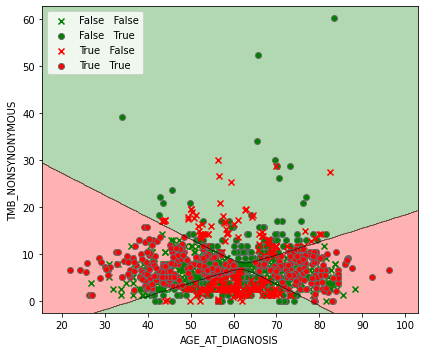

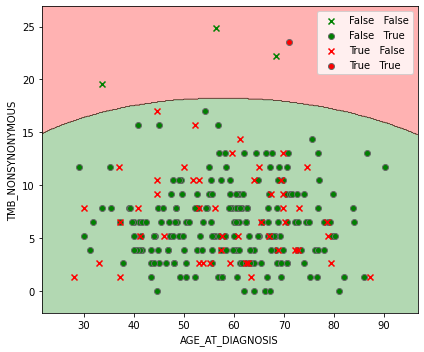

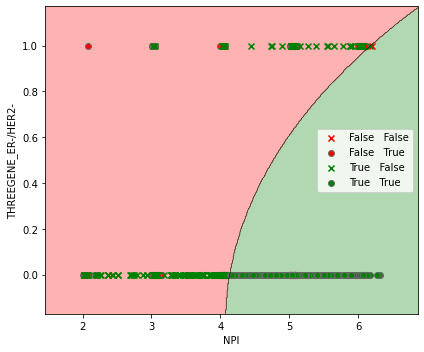

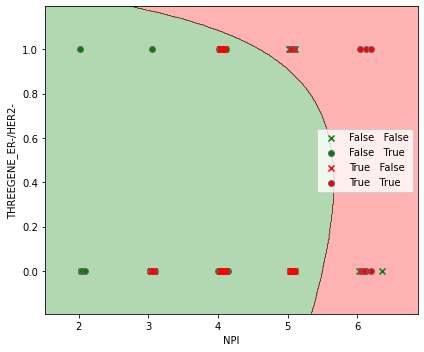

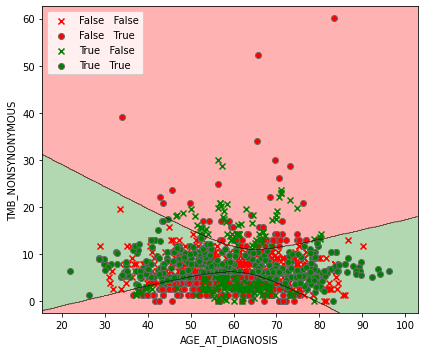

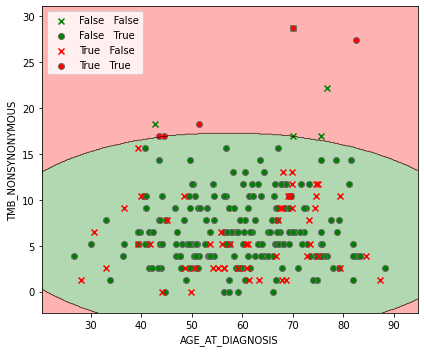

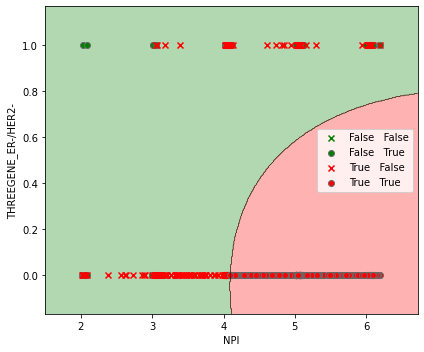

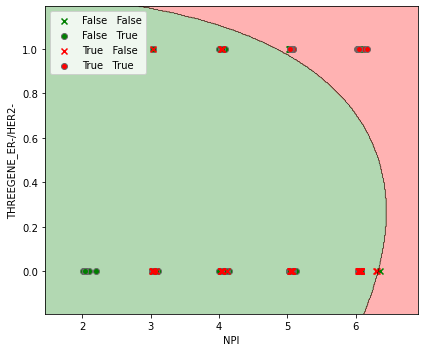

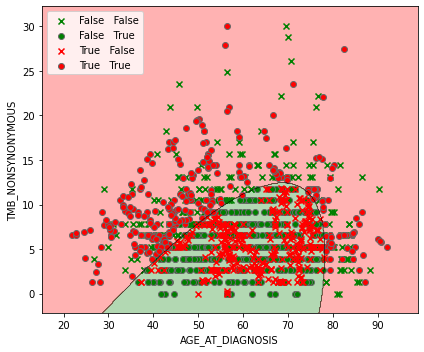

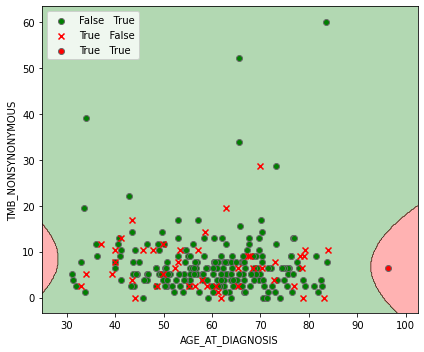

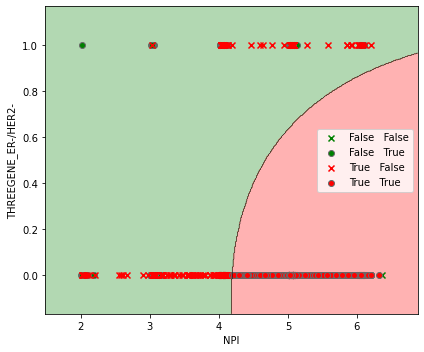

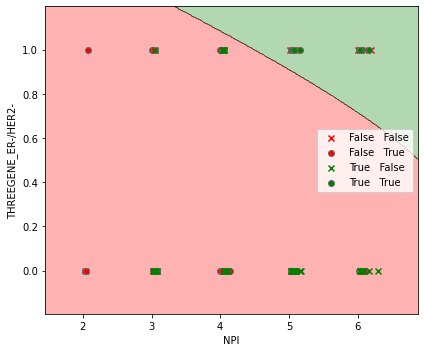

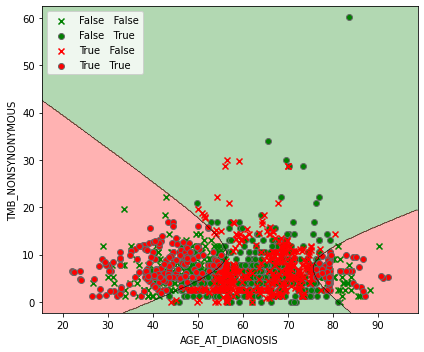

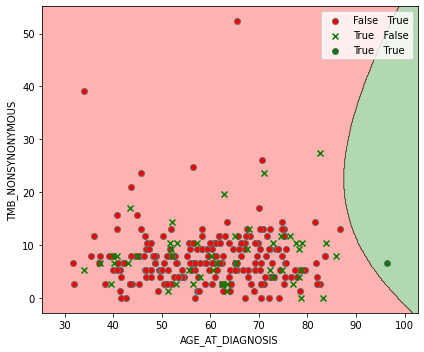

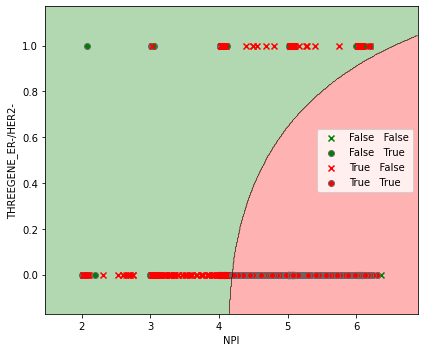

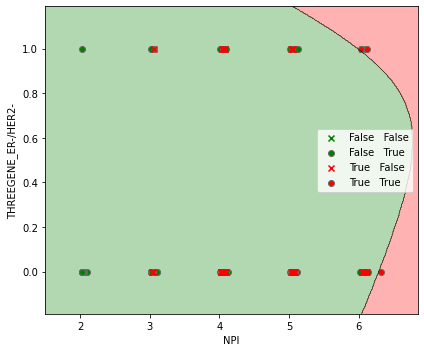

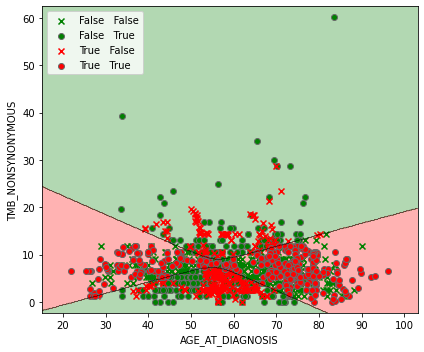

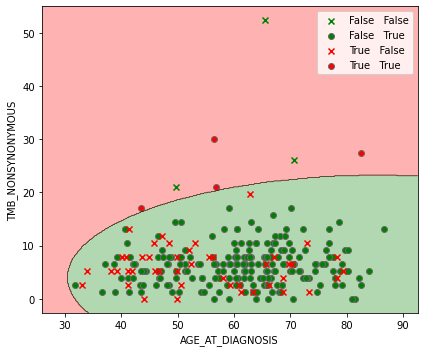

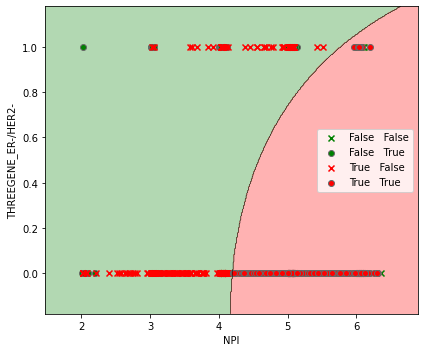

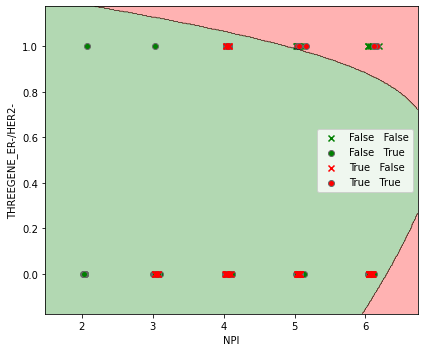

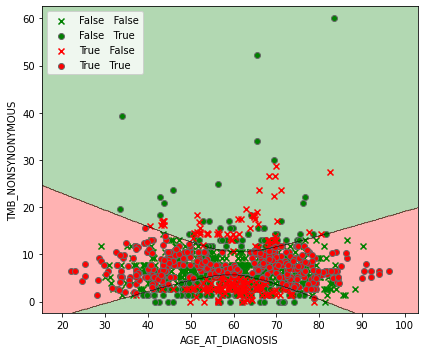

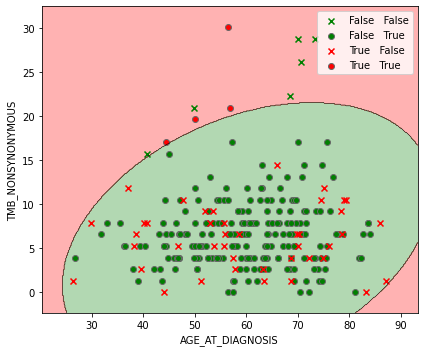

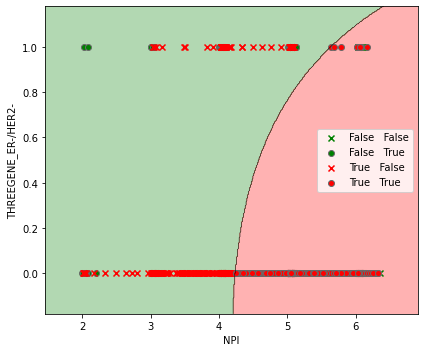

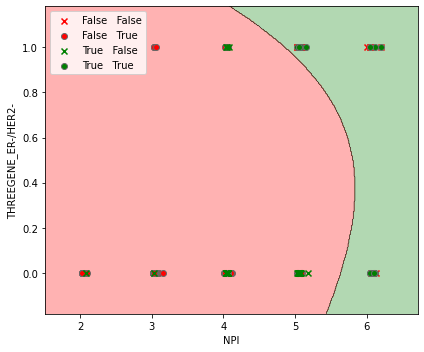

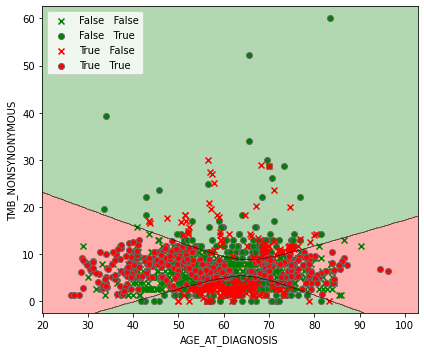

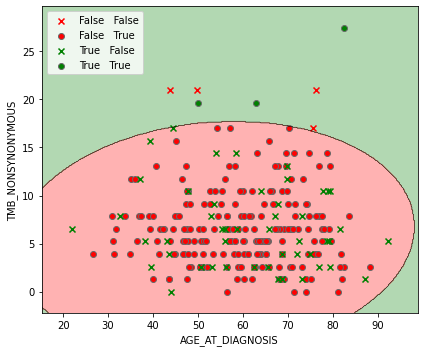

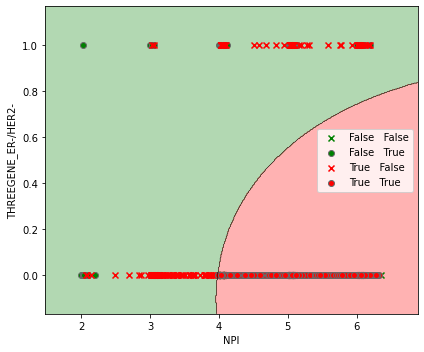

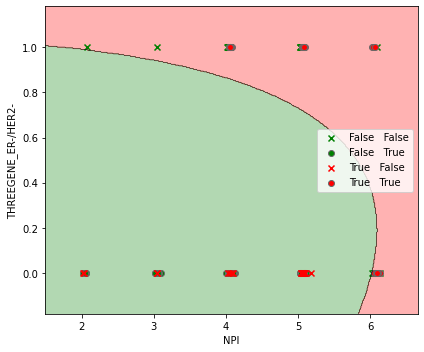

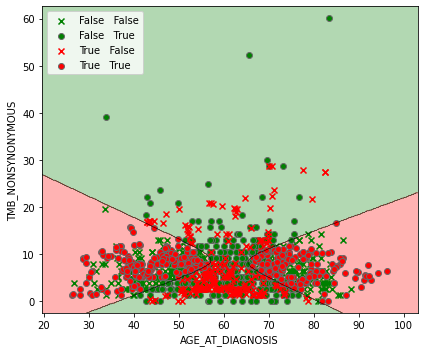

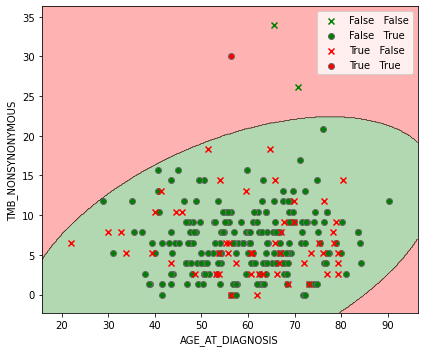

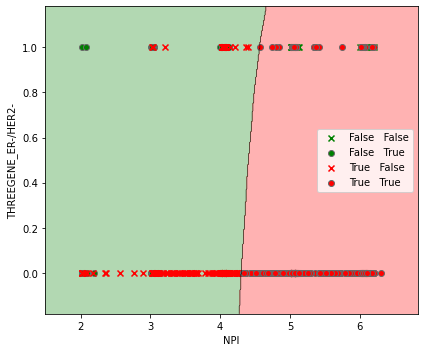

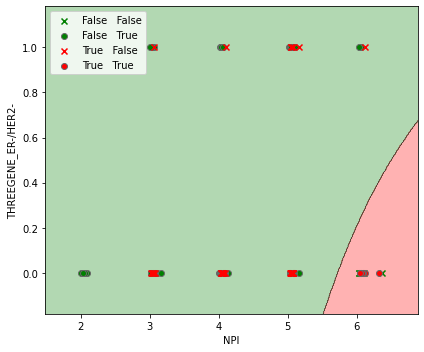

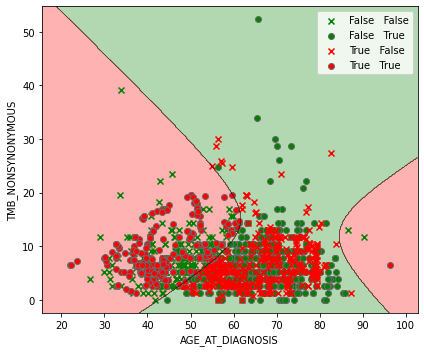

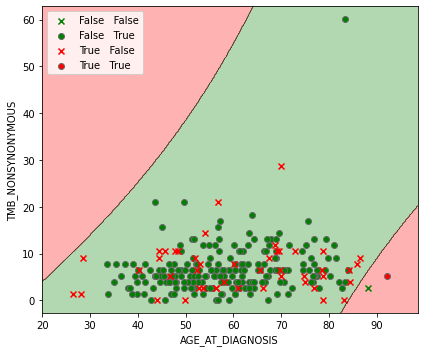

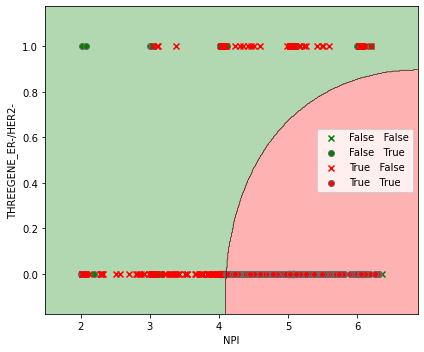

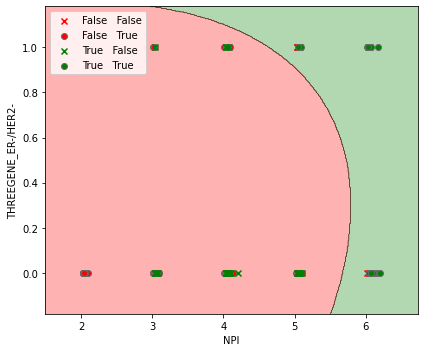

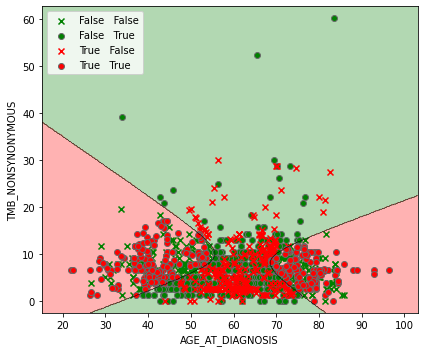

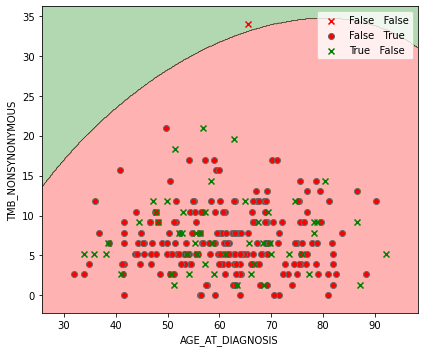

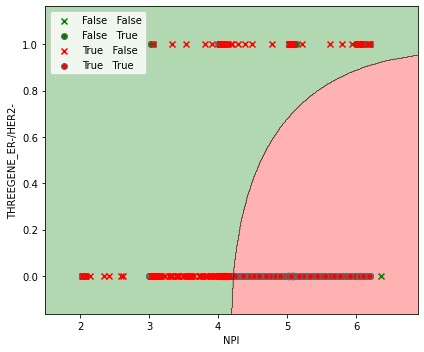

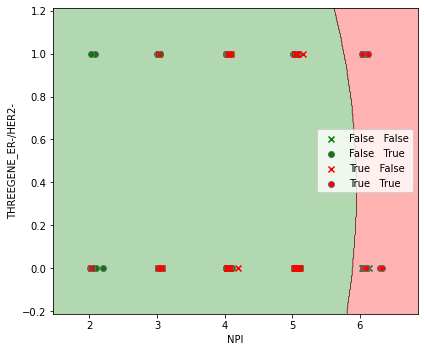

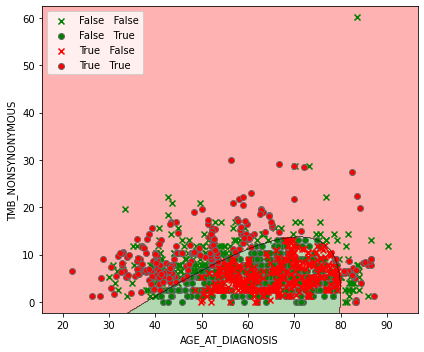

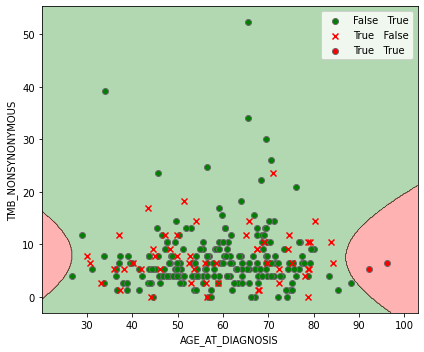

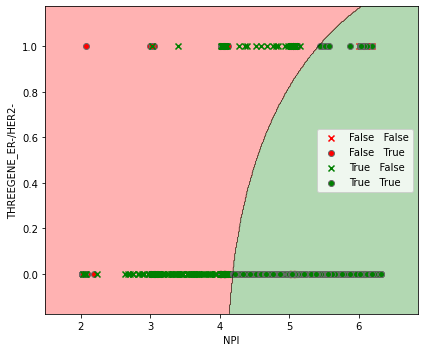

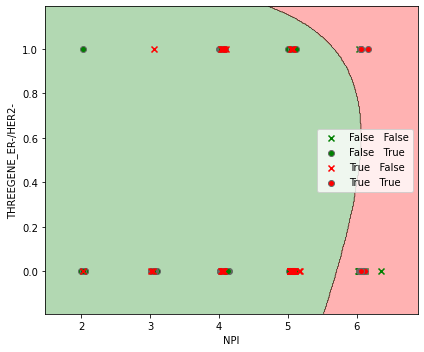

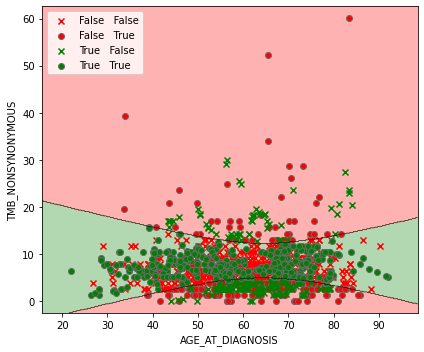

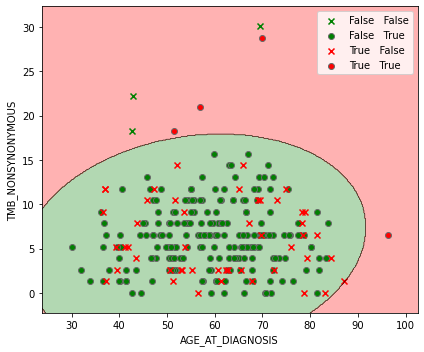

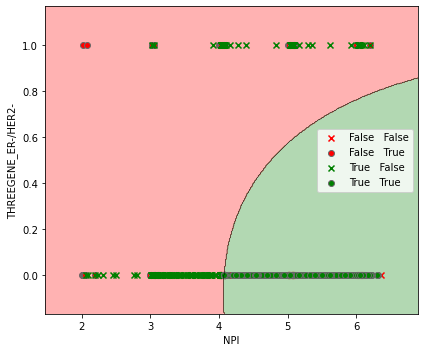

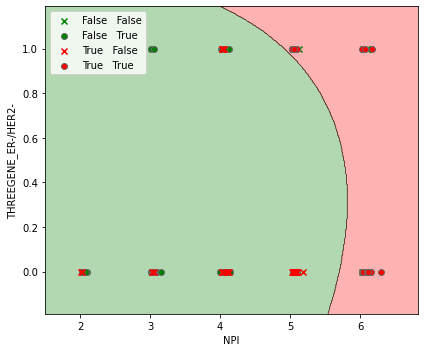

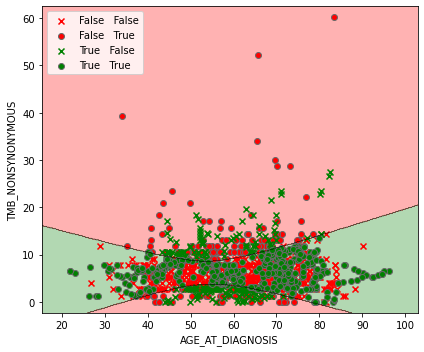

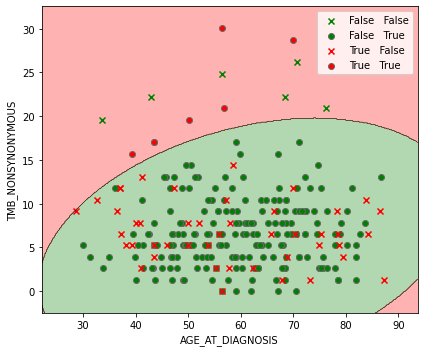

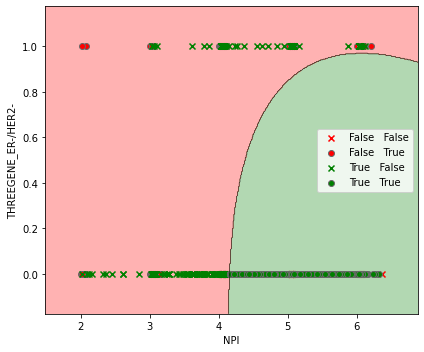

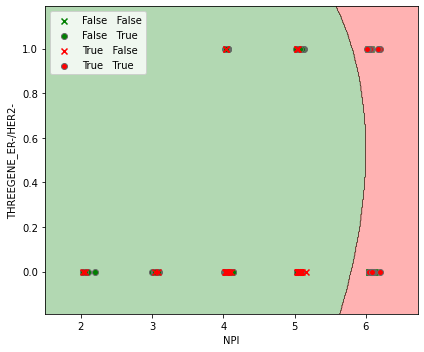

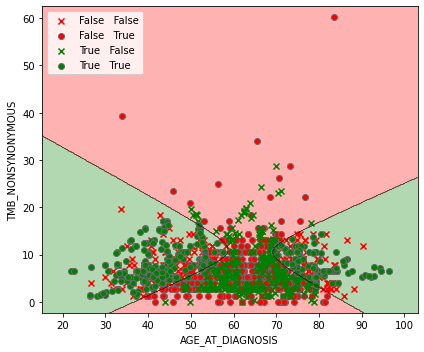

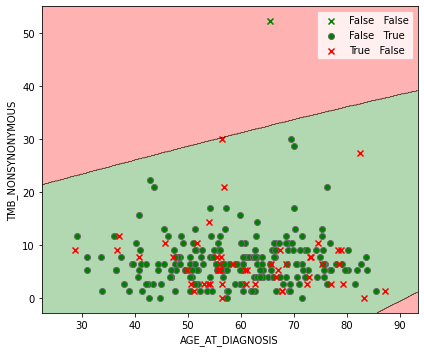

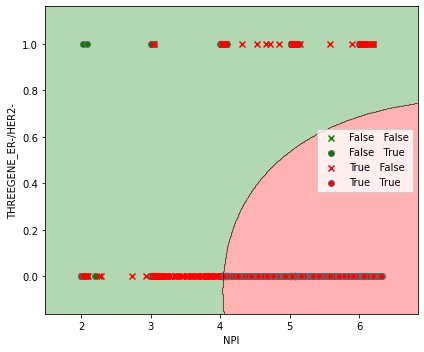

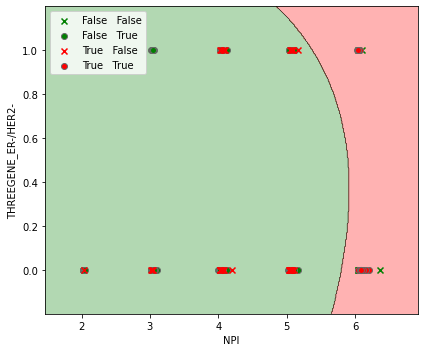

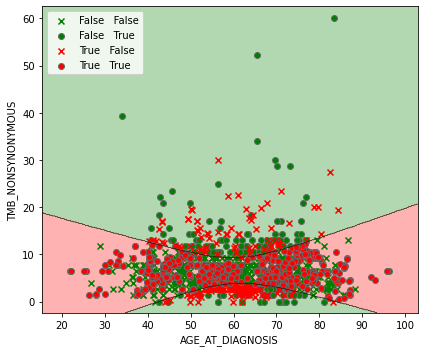

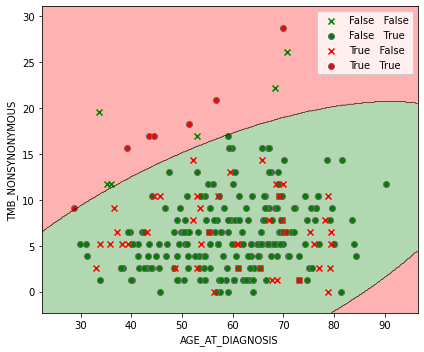

In [48]:
compare_bcms(over_sampling=SMOTE())

## 決定木モデルの構築・検証

決定木モデルを構築し、検証していく。  
パラメータを操作するため、forループで回し、最もスコアの高いものを見ていく。

In [43]:
import warnings

warnings.filterwarnings("ignore")  # lrで警告が出て視認性が悪いので、いったん非表示

accuracies_tree = {}
precisions_tree = {}
recalls_tree = {}
f1_scores_tree = {}

for nodes_num in range(2, 50):
    clf_tree = DecisionTreeClassifier(
        max_leaf_nodes=nodes_num, random_state=config.SEED
    )
    clf_tree = clf_tree.fit(X_resampled, y_resampled)

    y_pred_tree = clf_tree.predict(X_test)

    accuracies_tree[nodes_num] = accuracy_score(y_test, y_pred_tree)
    precisions_tree[nodes_num] = precision_score(y_test, y_pred_tree)
    recalls_tree[nodes_num] = recall_score(y_test, y_pred_tree)
    f1_scores_tree[nodes_num] = f1_score(y_test, y_pred_tree)

    print("nodes_num: ", nodes_num)
    show_scores(y_test, y_pred_tree)
    print("----------" * 10)

warnings.filterwarnings("always")

nodes_num:  2
accuracy:  0.735632183908046
precision:  0.4166666666666667
recall:  0.6363636363636364
f1 score:  0.5035971223021583
----------------------------------------------------------------------------------------------------
nodes_num:  3
accuracy:  0.7777777777777778
precision:  0.47619047619047616
recall:  0.5454545454545454
f1 score:  0.5084745762711864
----------------------------------------------------------------------------------------------------
nodes_num:  4
accuracy:  0.7011494252873564
precision:  0.37362637362637363
recall:  0.6181818181818182
f1 score:  0.4657534246575342
----------------------------------------------------------------------------------------------------
nodes_num:  5
accuracy:  0.7777777777777778
precision:  0.47619047619047616
recall:  0.5454545454545454
f1 score:  0.5084745762711864
----------------------------------------------------------------------------------------------------
nodes_num:  6
accuracy:  0.7777777777777778
precision:  0.4594

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.358195,0.359387,0.362392,0.358269
Decision Tree,1.000000,0.753065,1.000000,0.353964
Quadratic Discriminant Analysis,0.214020,0.214943,0.324962,0.325993
AdaBoost,0.854738,0.800000,0.514669,0.321796
Logistic Regression,0.833931,0.814176,0.388994,0.302154
Random Forest,1.000000,0.811877,1.000000,0.263831
Nearest Neighbors,0.848143,0.797318,0.438559,0.227304
Linear SVM,0.830986,0.813410,0.294379,0.220826
Sigmoid SVM,0.805058,0.804789,0.088384,0.093911


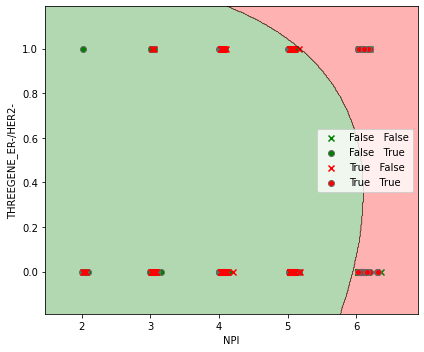

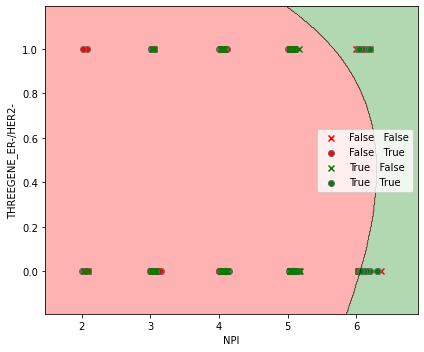

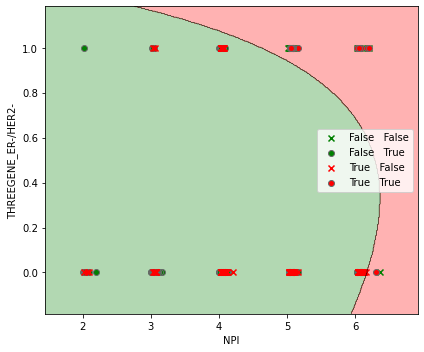

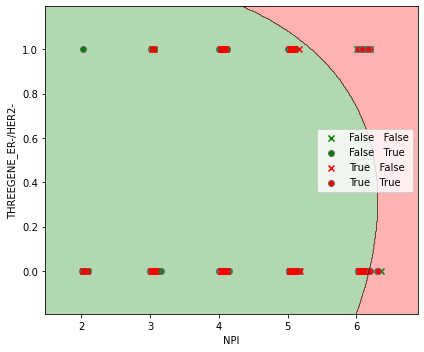

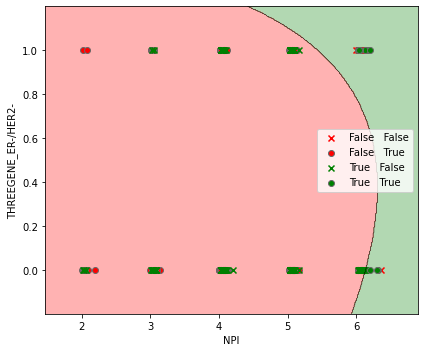

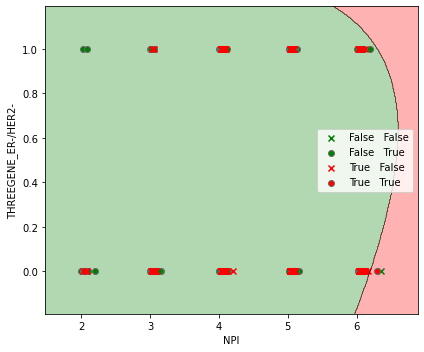

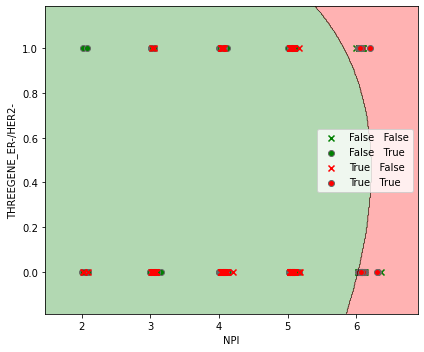

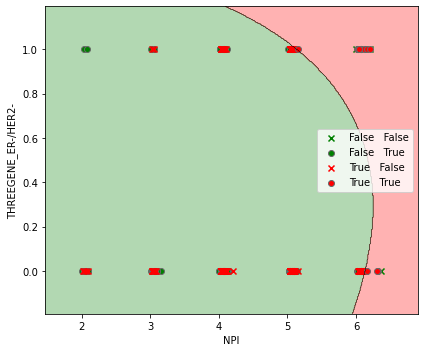

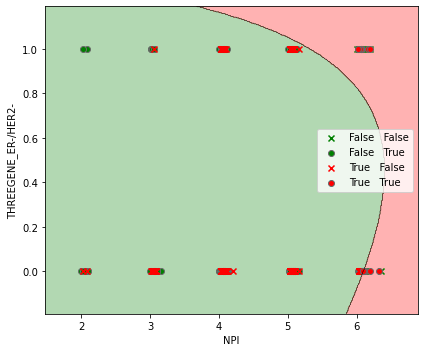

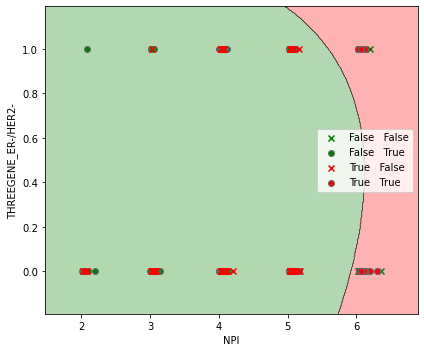

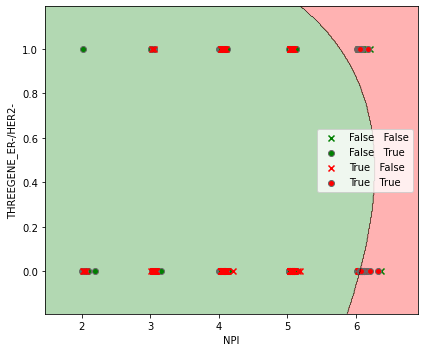

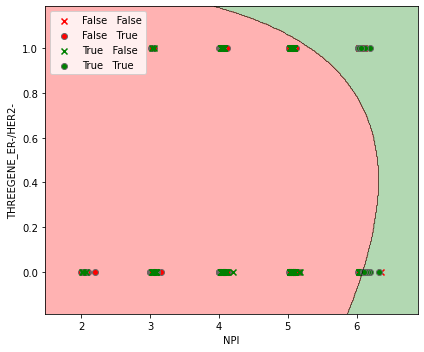

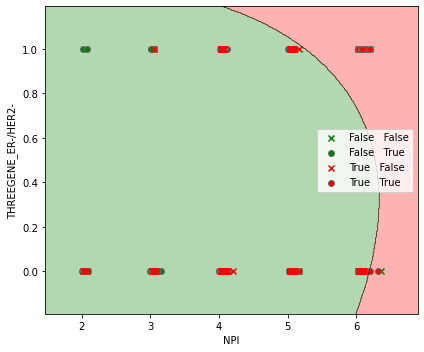

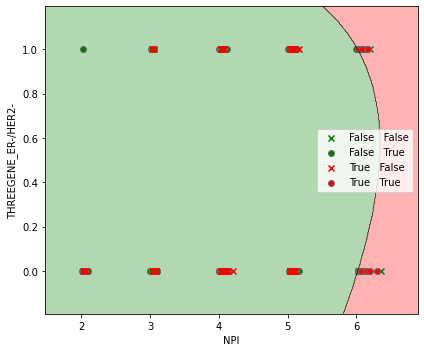

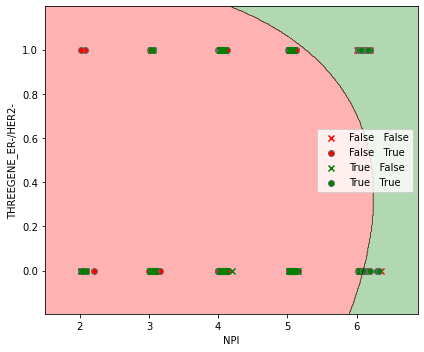

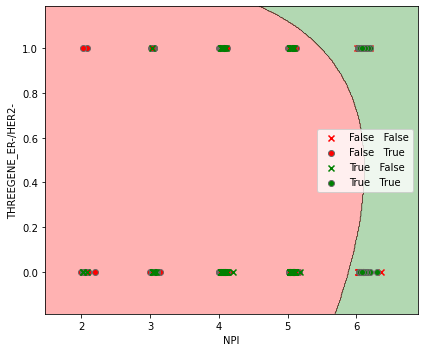

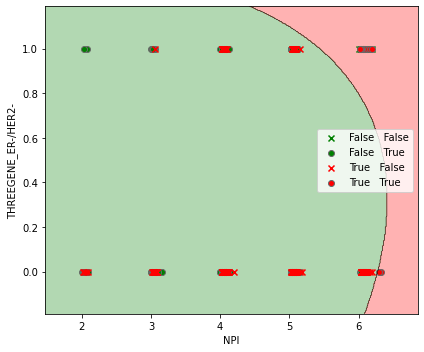

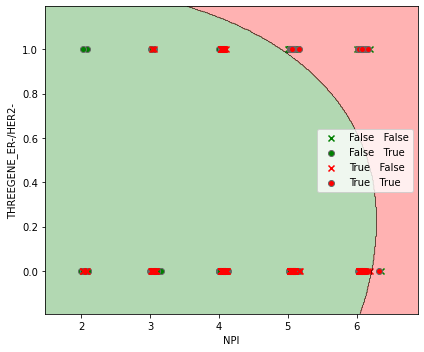

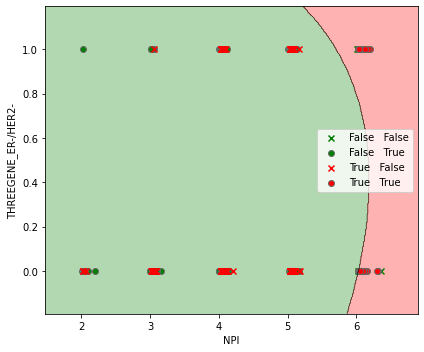

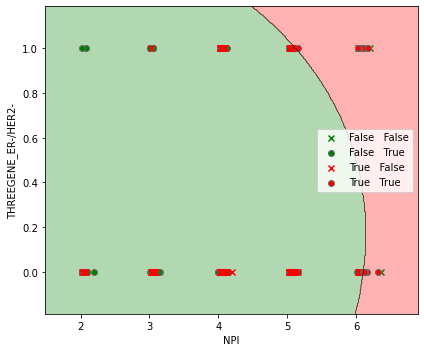

In [44]:
compare_bcms()

'max nodes_num'

8

8

2

3

accuracy:  0.7777777777777778
precision:  0.47619047619047616
recall:  0.5454545454545454
f1_score:  0.5084745762711864


Text(0, 0.5, 'score')

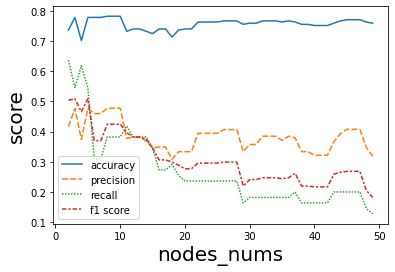

In [45]:
# 各スコアのプロット
display(
    "max nodes_num",
    max(accuracies_tree, key=accuracies_tree.get),
    max(precisions_tree, key=precisions_tree.get),
    max(recalls_tree, key=recalls_tree.get),
    max(f1_scores_tree, key=f1_scores_tree.get),
)

# f1_scoreが最も高いモデルのスコア
print(
    "accuracy: ",
    accuracies_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)
print(
    "precision: ",
    precisions_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)
print(
    "recall: ",
    recalls_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)
print(
    "f1_score: ",
    f1_scores_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)

df_score_tree = pd.DataFrame(
    [accuracies_tree, precisions_tree, recalls_tree, f1_scores_tree],
    index=["accuracy", "precision", "recall", "f1 score"],
    columns=accuracies_tree.keys(),
).T
p = sns.lineplot(data=df_score_tree)
p.set_xlabel("nodes_nums", fontsize=20)
p.set_ylabel("score", fontsize=20)

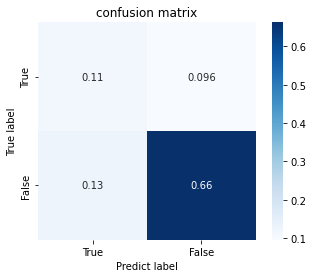

In [46]:
clf_tree = DecisionTreeClassifier(
    max_leaf_nodes=max(f1_scores_tree, key=f1_scores_tree.get),
    random_state=config.SEED,
)
clf_tree = clf_tree.fit(X_resampled, y_resampled)
y_pred_tree = clf_tree.predict(X_test)
show_confusion_matrix(y_test, y_pred_tree)